In [30]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import openai
import re
import time
from scripts.prepare_data_helpers import prepare_examples, create_query
import spacy
import textacy
from dotenv import load_dotenv

load_dotenv()
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.cluster import KMeans
import kmedoids

## Prepare Data

In [2]:
train1 = pd.read_csv('../../e-SNLI/dataset/esnli_train_1.csv')
train2 = pd.read_csv('../../e-SNLI/dataset/esnli_train_2.csv')
train = pd.concat([train1, train2])
dev = pd.read_csv('../../e-SNLI/dataset/esnli_dev.csv')
test = pd.read_csv('../../e-SNLI/dataset/esnli_test.csv')

train = train.dropna(subset=['Sentence1', 'Sentence2', 'Explanation_1'])
train = train.reset_index(drop=True)

np.random.seed(12345) # seed for numpy package
test_indices = list(np.random.choice(test.index.values, size=1000, replace=False))
test = test.loc[test_indices]
test = test.reset_index(drop=True)

In [3]:
gpt_pred = pd.read_csv('../output_data/svo_structure_4.csv', sep=';')
# Transform list to single string
gpt_pred.reduced_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.reduced_expl]
gpt_pred.pos_expl = [i.replace("'", " ").replace(" ", "").strip("][").replace(",", " ") for i in gpt_pred.pos_expl]

# Cluster Reduced Explanations

## PAM Clustering

### SVO Structure

In [5]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt_pred.reduced_expl)

In [28]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


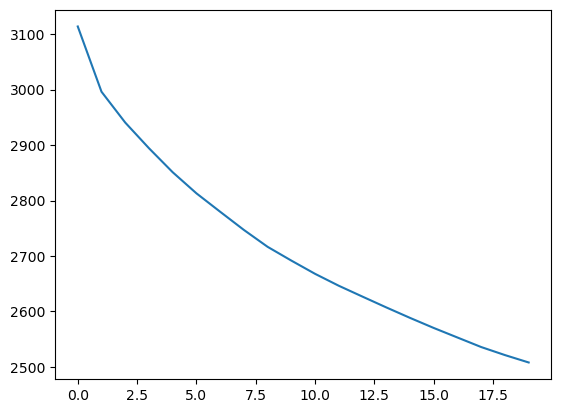

In [105]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [106]:
for i in range(len(SSD)):
    print("------------------")
    print(gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_expl)
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
imply
Medoid class: entailment
entailment    33
neutral        3
Name: pred_label, dtype: int64
------------------
not mean
Medoid class: neutral
neutral          45
contradiction    13
Name: pred_label, dtype: int64
------------------
S1_Verb S1_Obj be
Medoid class: entailment
entailment       24
contradiction     7
neutral           2
Name: pred_label, dtype: int64
------------------
S2_Verb
Medoid class: entailment
entailment       72
contradiction    70
neutral          15
Name: pred_label, dtype: int64
------------------
S1_Subj S1_Verb imply
Medoid class: entailment
entailment       15
contradiction     5
Name: pred_label, dtype: int64
------------------
be S2_Verb S2_Obj
Medoid class: entailment
entailment       21
contradiction     5
neutral           1
Name: pred_label, dtype: int64
------------------
be not same
Medoid class: contradiction
contradiction    32
Name: pred_label, dtype: int64
------------------
imply S1S2_Subj S2_Verb S2_Obj
Medoid class: cont

### SVO Structure

In [107]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(gpt_pred.pos_expl)

In [108]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


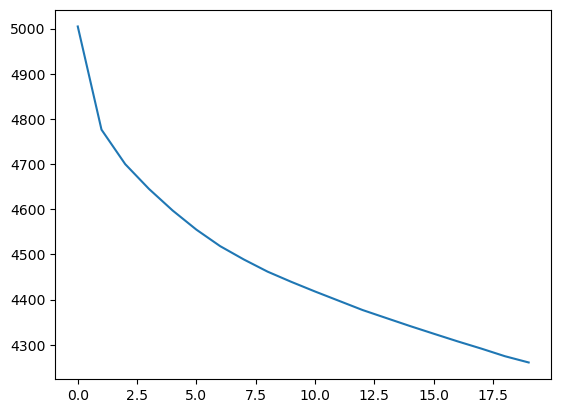

In [109]:
SSD = list()
for k in range(1,21):
    km = kmedoids.KMedoids(n_clusters=k, method="pam")
    kmfit = km.fit(metrics.pairwise.euclidean_distances(X))
    SSD += [kmfit.inertia_]
plt.plot(SSD)

In [112]:
for i in range(len(SSD)):
    print("------------------")
    print(f"Actual Expl: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_explanation}")
    print(f"SVO Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].reduced_expl}")
    print(f"POS Structure: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pos_expl}")
    print(f"Medoid class: {gpt_pred.iloc[kmfit.medoid_indices_[i]].pred_label}")
    print(gpt_pred[kmfit.labels_ == i].pred_label.value_counts())

------------------
Actual Expl: The crowd could be watching the duo in blue dance on a stage or sitting in a lounge.
SVO Structure: S1_Subj watch S1_Verb S1_Obj S2_Verb
POS Structure: S1_NOUN be S1_VERB S1_NOUN S1_ADJ S1_NOUN S1_NOUN S2_VERB S2_NOUN
Medoid class: neutral
entailment       16
contradiction     7
neutral           2
Name: pred_label, dtype: int64
------------------
Actual Expl: A group of cyclists at a race implies that they are racing.
SVO Structure: S2_Subj S2_Verb imply S2_Verb
POS Structure: S1S2_NOUN S1S2_NOUN S1S2_NOUN imply be S1S2_NOUN
Medoid class: entailment
entailment       20
contradiction     1
neutral           1
Name: pred_label, dtype: int64
------------------
Actual Expl: Pitching the ball is the same as throwing the ball.
SVO Structure: S1_Verb S1S2_Obj be same S2_Verb S1S2_Obj
POS Structure: S1_VERB S1S2_NOUN be S2_VERB S1S2_NOUN
Medoid class: entailment
entailment       41
neutral          23
contradiction    12
Name: pred_label, dtype: int64
---------